# Data Analysis (EDA) 
___

EDA (Exploratory Datat Analysis) is the process of examining the data at hand. This can help us decide which features should be used for training the models and which features should be discarded. There are other benefits as well, examining the distributions allows us to pick more appropriate machine learning models as different models excel at dealing with different types of of distributions.

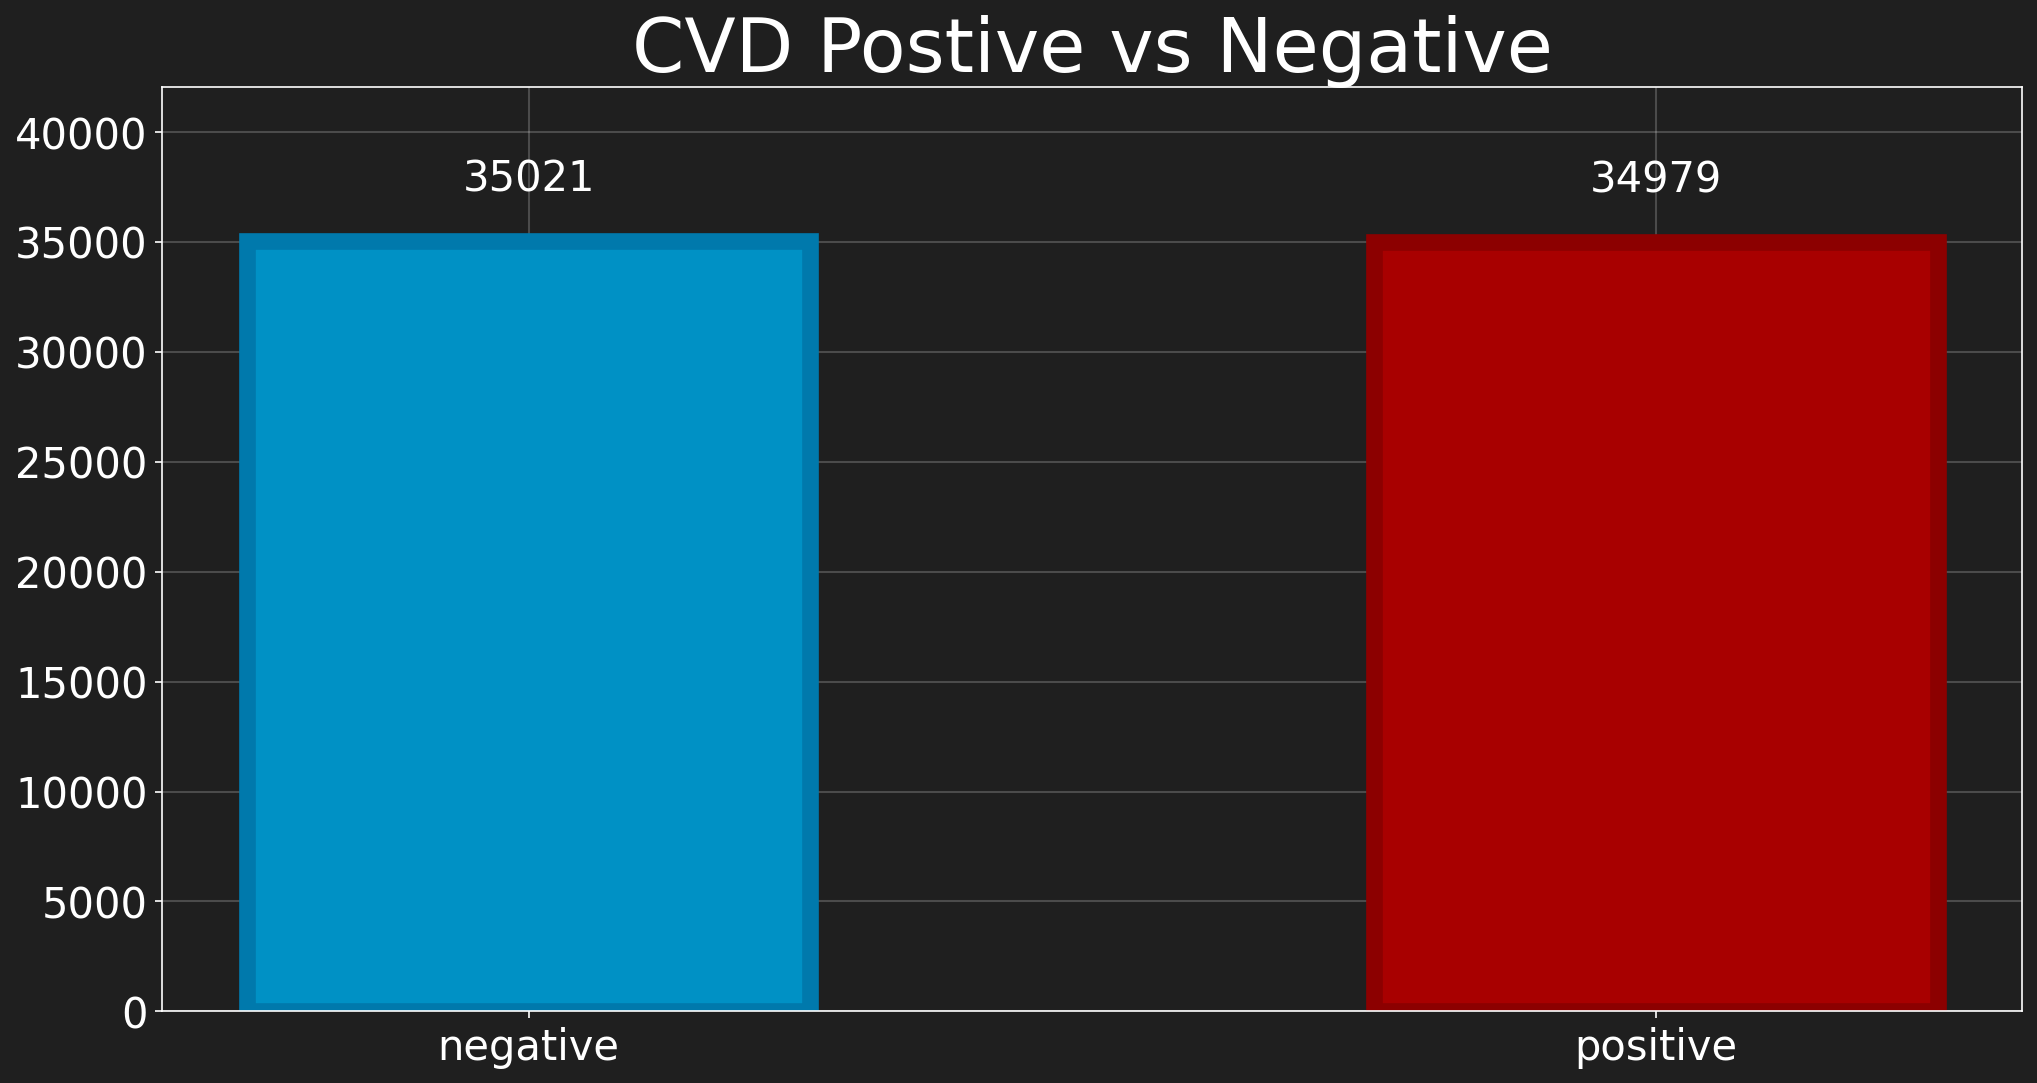

In [2]:
import eda
import pandas as pd
from mpl_style_sheet import style_sheet, cpa
import matplotlib.pyplot as plt

path = "data/"
df = pd.read_csv(path+"cardio_train.csv", sep=";")
df.drop(columns="id", inplace=True)

for key, val in style_sheet.items(): plt.rcParams[key]=val

eda.plot_cvd(df, plt, cpa)

This bar chart shows that the distribution between patients that have tested positive/negative for CVD is relatively balanced, balanced data tends to make the models more reliable.

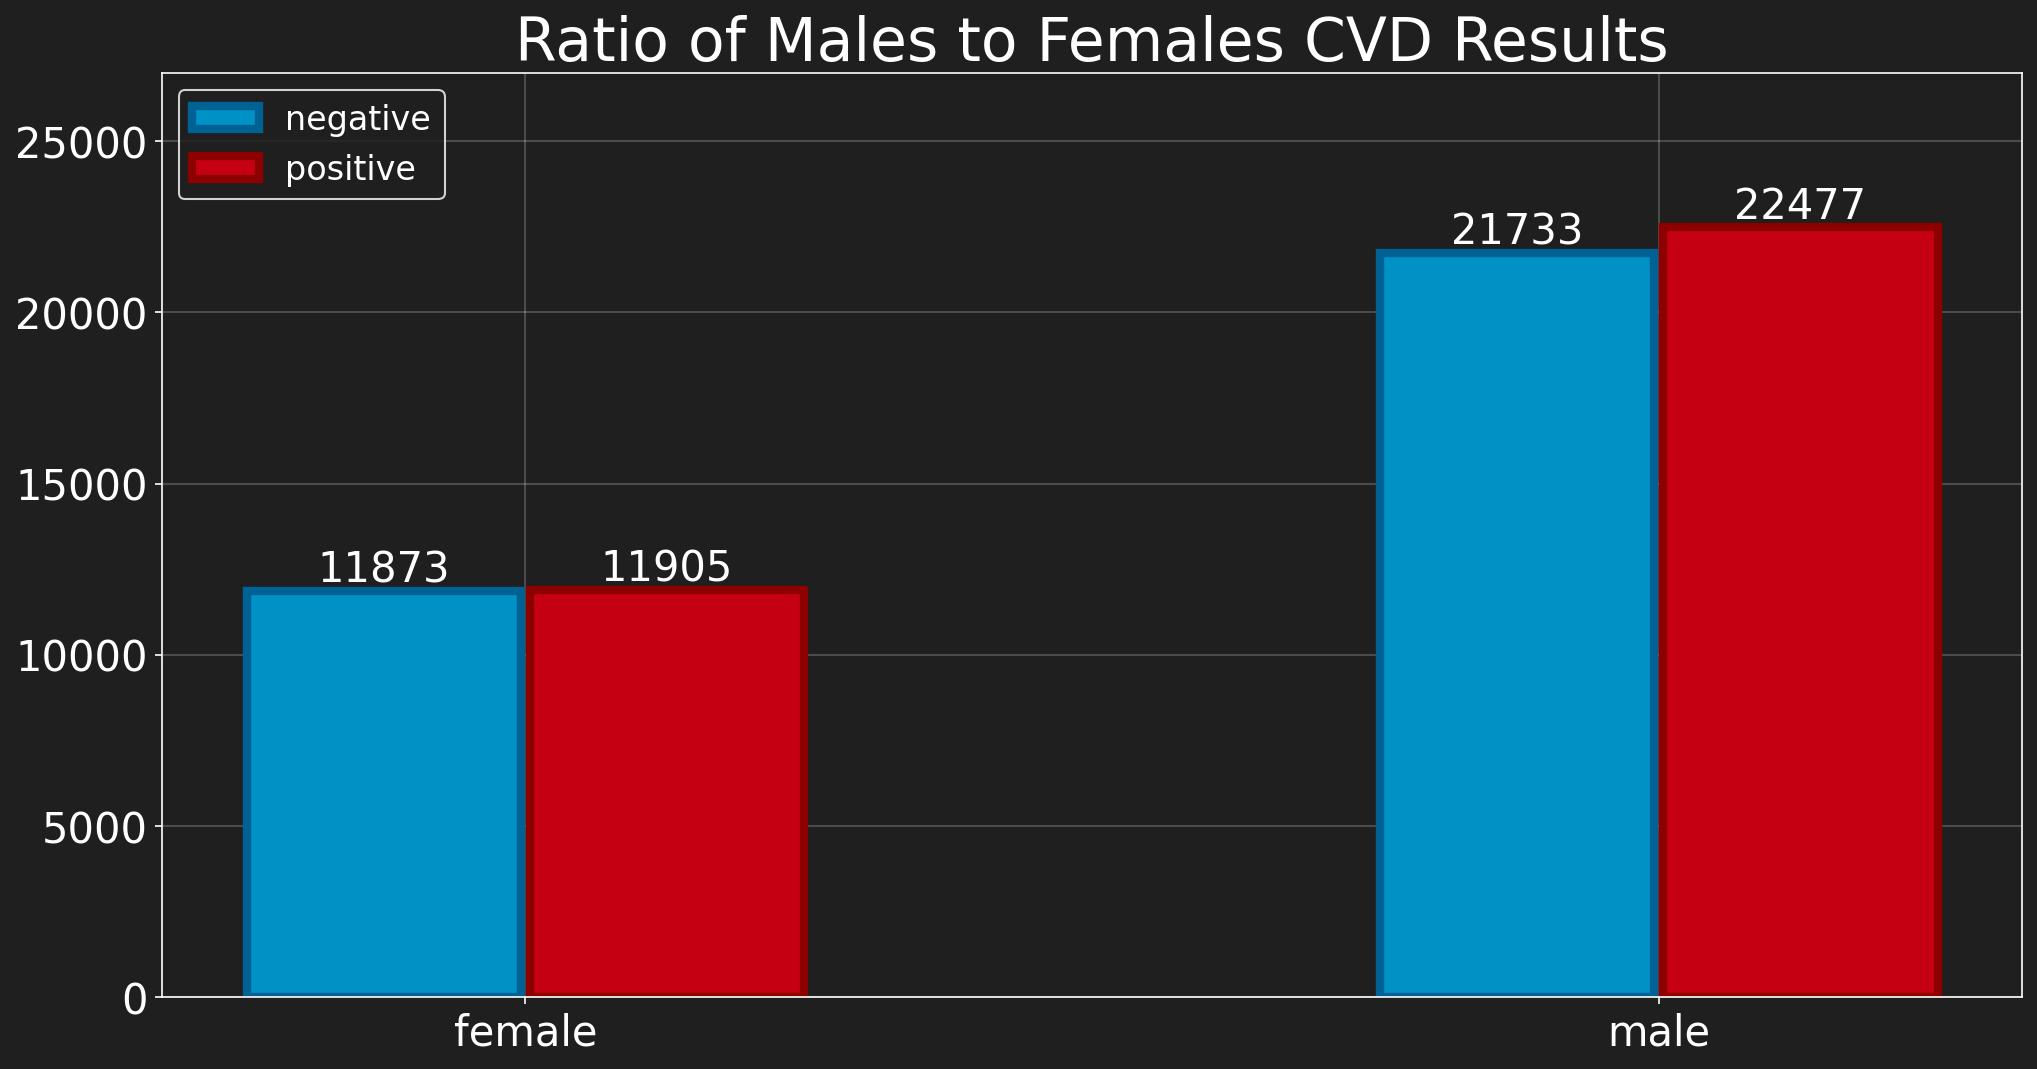

In [5]:
eda.plot_gender(df, plt, cpa)

This again is testing positive/negative for CVD but broken up in to genders

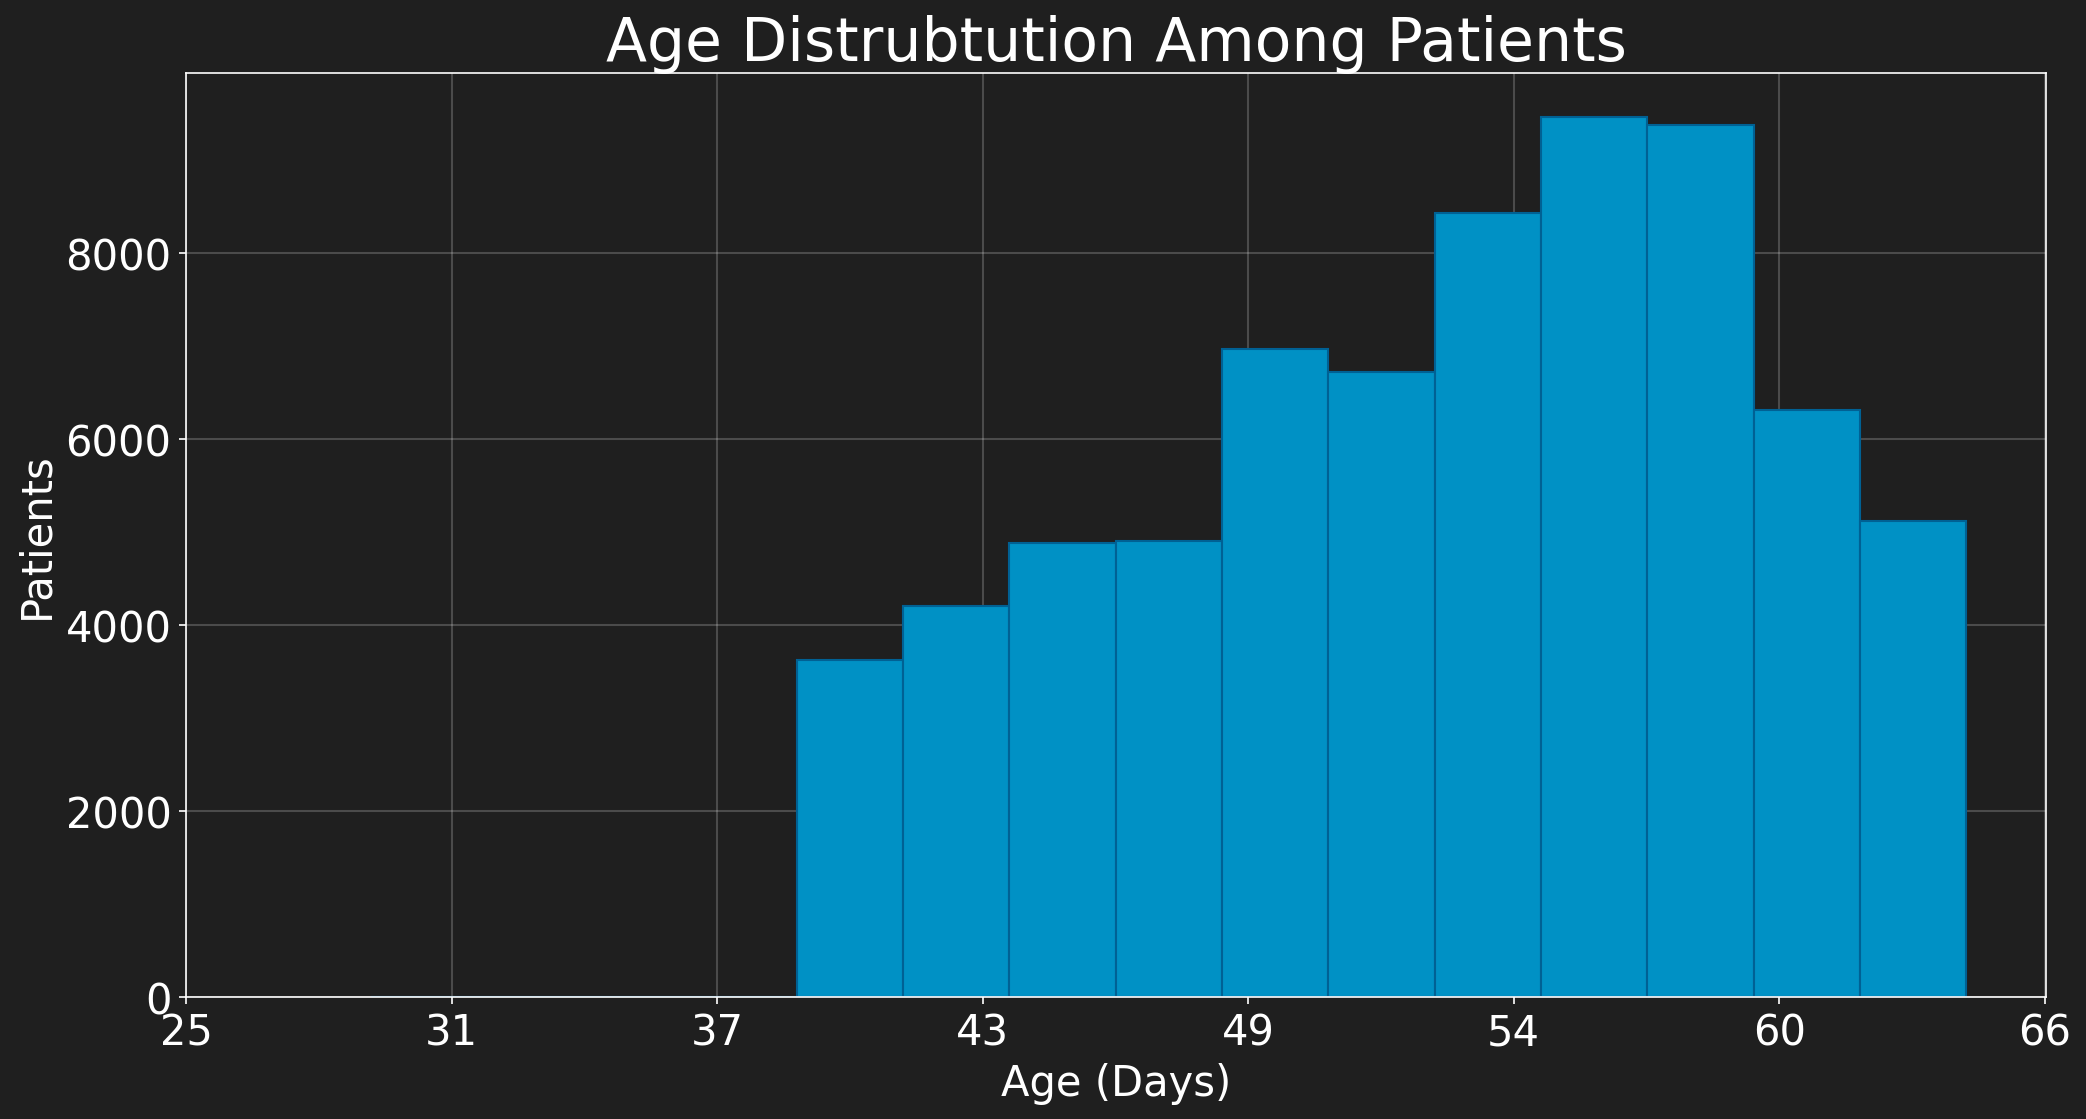

In [3]:
eda.plot_age(df, plt, cpa)


This Histogram illustrates the age distribution and shows that age range of the sample size.

# Feature Engineering
___

The machine learning models will only be as good as the data there being trained on. To increase the accuracy of the models, features can be removed or combined based on there correlation between each other and the target. A heat map helps us visualize correlations between features.

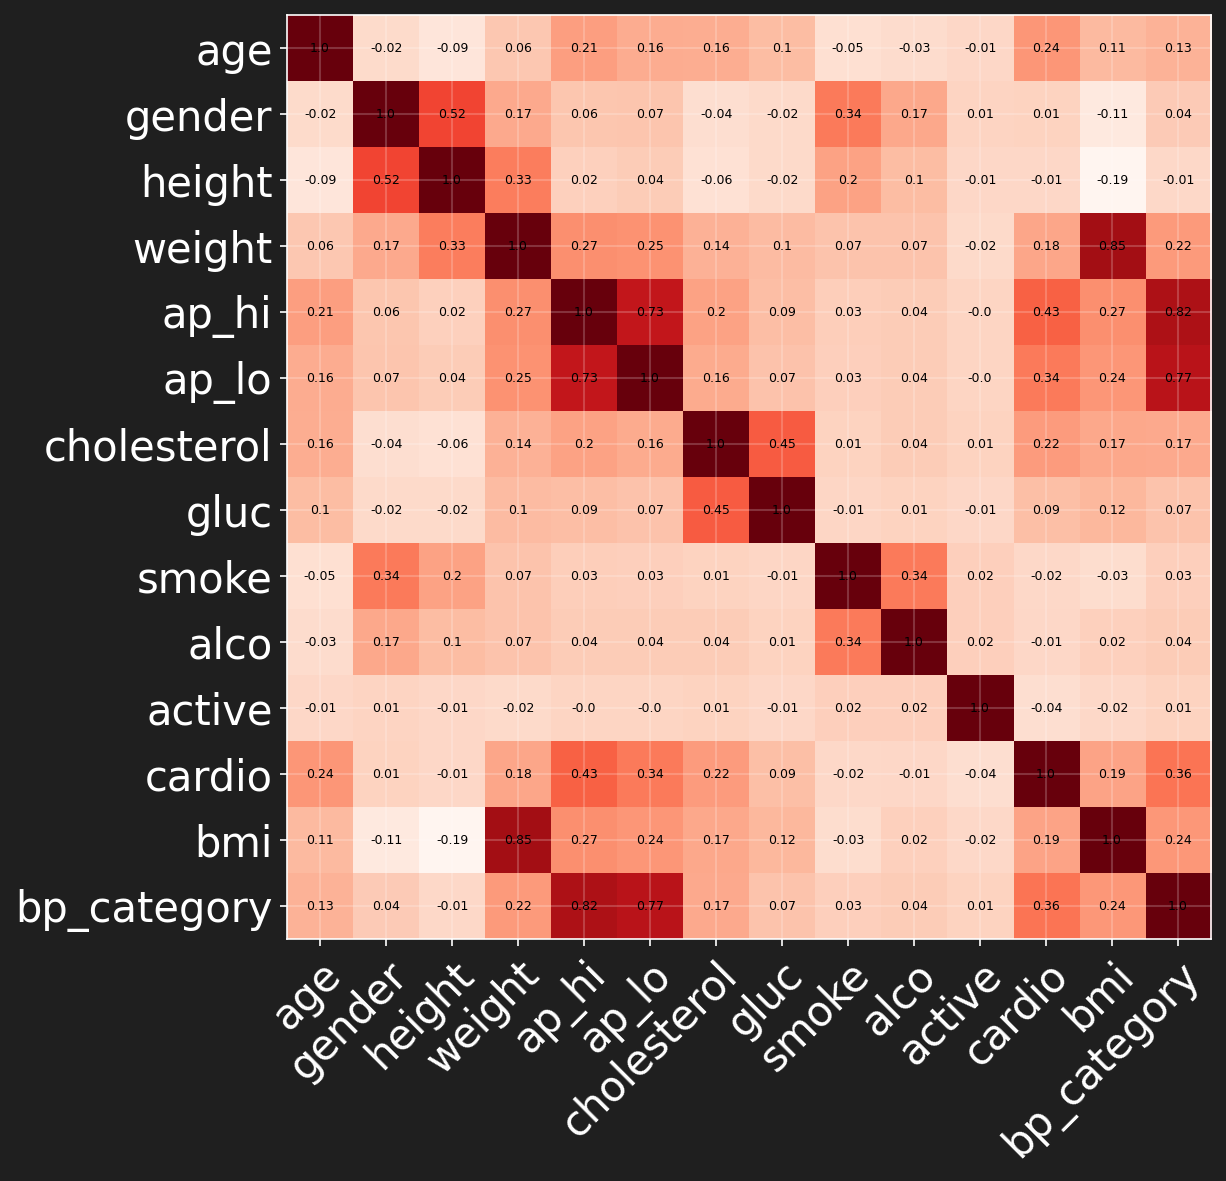

In [3]:
df = eda.bmi(df)
df = eda.blood_preassure(df)
eda.plot_heatmap(df, plt, drop="bmi_category" )


### Body Mass Index (BMI)

Height and Weight can be combined in to a new feature BMI, using the following formula:  
$$ \frac{weight}{(height/100)^2}$$


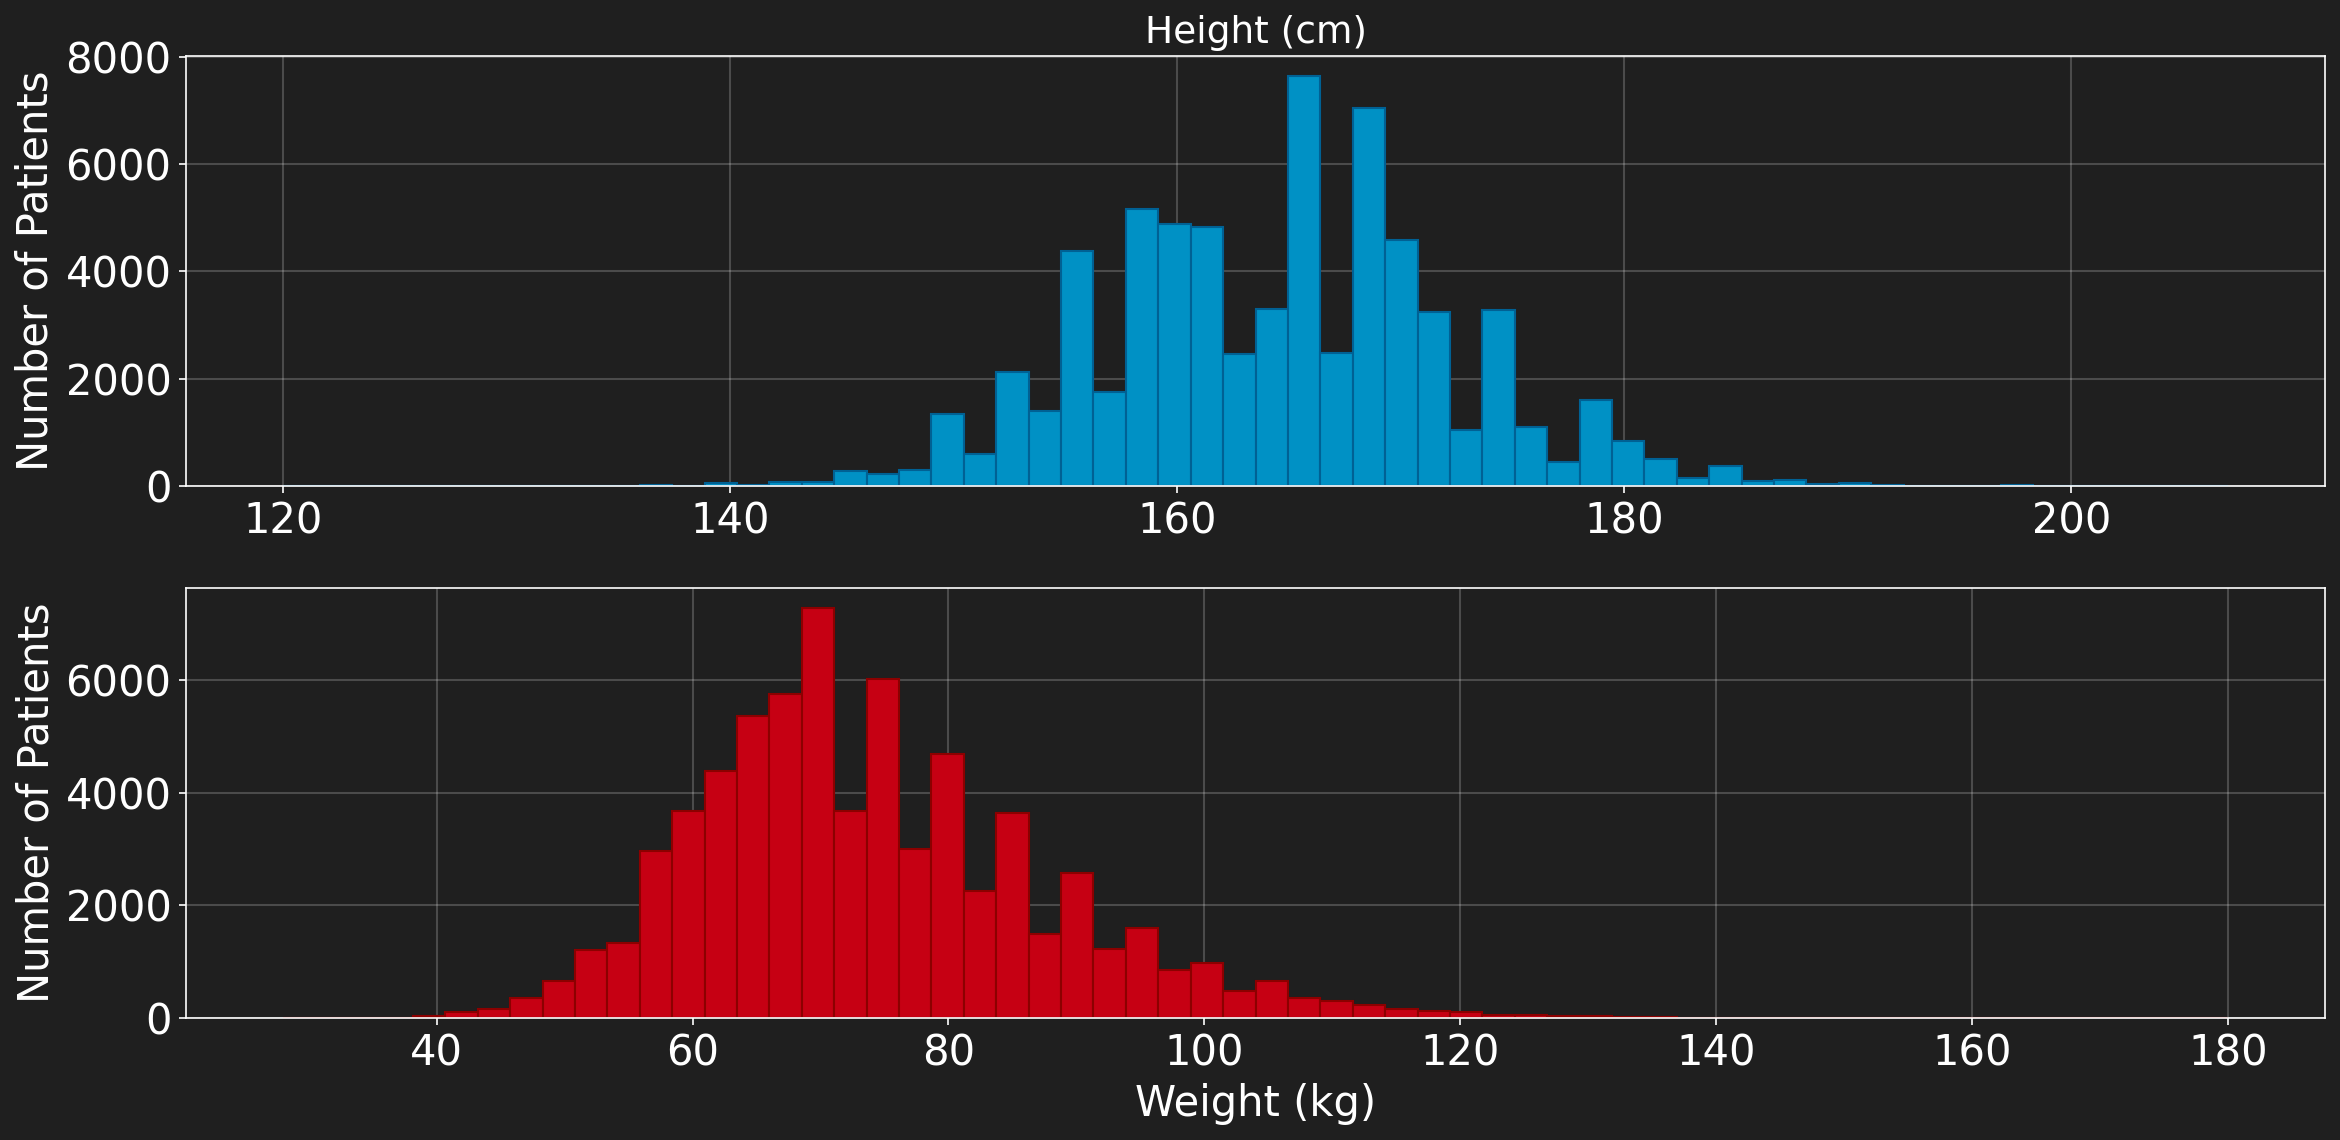

In [4]:
eda.plot_height_weight(df, plt, cpa)

### Blood Preassure 
Blood Preassure is another feature that can be created by combining two existing features, namely Systolic Blood Preassure and Diastolic Blood Preassure.

The featurs are rescaled and then used to calculate the different categories of blood preassure:
Hypertension Crisis, Hypertension Stage 2, Hypertension Stage 1, Elevated and Healthy.

### Datasets
Based on the EDA and Heatmap a new dataset can be created that contains the Features that will have the greatest impact on the prediction. In this case two sets are made to provide data for future Feature Engineering.

In [11]:
from validator import ModelValidator, create_datasets

# Features being included, not dropped
X_labels = [ 
  ["age", "gender", "cholesterol", "gluc", "smoke", "alco", "active", "bp_category", "bmi_category"],
  # Not Included [ "weight", "height", "bmi", "ap_hi", "ap_lo", "cardio"] 
  ["age", "gender", "cholesterol", "gluc", "smoke", "alco", "active", "bmi", "ap_hi", "ap_lo", ] 
  # Not Included [ "weight", "height", "bp_category", "bmi_category", "cardio"]
]
y_labels = [ "cardio", "cardio" ]
onehot = [ ["bp_category", "bmi_category", "gender"], ["gender"] ]
datasets = create_datasets(df, X_labels, y_labels, onehot, size=None)

# Modells 
___

To increase the accuracy of the classifications six models will be chosen and then trained on the both sets, the model set combination that produces the highest score will be used in the final evaluation.

The models where chosen, primarily, to provide the greatest possible variety while still fall inside the range of models commonly used for classification. Some models such as SVC where excluded because of hardware limitations in the test equipment.

What follows are as short explanation on the six models that have been chosen and the hyper parameters that is used during the tuning process.
Note that many of the parameters have been limited or ignored primarily because of hardware constraints, to find the best parameters a greater ranged could have been chosen: 

##### Decision Trees
A Tree-based mode that makes decision in a way not unlike a big nested if else statement.
- `criterion ["gini", "entropy"]`
	  This determines how the model splits the data at each node.
	  Gini is often used for classification as it measures the probability of misclassification. 
	  Entropy also common for classification and it measure the disorder or uncertainty of the data.
	  We also have Squared Error, Absolute Error and Friedman MSE, but these are skipped because there primarily used for regression. 

- `max_depth [3,6,9,12,15]` 
	This limits how deep the tree can grow, the deeper the tree the more complex it is which reduces the chance for overfit but it might also lose some of the relevant information.

 - `min_sample_split [2,4,8,10]
	Determines how many samples are required to split an internal node. A high value prevents the tree from creating very small nodes which can lead to overfitting, in a sens it smooths out the decision boundaries.

- `min_sample_leaf [1,3,6]`
	Sets the minimum number of samples required for a leaf node
	This might sound very similar to *Mini Sample Split* and it is, they both help to prevent overfitting by ensuring that the nodes don't get to small. The key difference is that a leaf is an end node so `Mini Sample Leaf` can prevents `Mini Sample Split` from splitting  an internal node in to two leaf nodes if the leaf nodes gets to small.

- `max_features [sqrt, log2, None]`
	Limits the number of features considered when searching for the best split. 
	Sqrt = $\sqrt{d}$
	Log2 = the base-2 logarithm of $d$
	None = $d$
	
	
- Best Combination
	`dataset_2, max_depth[9,12], min_sample_leaf[6], min_sample_split[10] criterion["entropy"]
	`md` is in the middle during two runs it shifted between 9 and 12 of the range but `msl` and `msl` both used the maximum so the ranges could be increased.

##### Gradient Boosting
Ensemble of decisions trees.
- `n_estimators [100, 200, 300]`
	 Represents the number of boosting steps aka how many sequential trees the algorithm will create in order to try and correct errors.  So the higher the number of `n_estimators` the more complex patterns the model can learn, but this will come computational cost and can also increase the chance for overfitting.

- `learing rate [0.01, 0.1, 0.2]`
	The lower the learning rate the less each tree will contribute to the classification decision, this can reduce the risk of overfitting. With a higher learning rate the model will learn more quickly but also have higher chance to overfit.
	*Learning Rate* and *The Number of Estimators* often go hand in hand as the number of estimators increases the learning rate needs to be lowered to prevent overfitting.

- Best Combination
	`dataset_2, n_estimators[300], learning_rate[0.2]`
	`n_estimators` and `learning_rate` reach ither maximum so the ranges should be increased.
  
##### K-Nearest Neighbors
A non-parametric model that determines the class base on the class of of the data points closest neighbors, good on low dimensional datasets such as these. 

- `n_neighbors [1, 2, 3, 5, 8, 13]`
	The most important hyper parameter for KNN is arguably how many neighbors to chose from, to few neighbors can lead to overfitting, to many can lead to a heigh bias. 13 is not necessarily a high number but the more neighbors the higher the computation time. Smaller steps will also increase computation time but would increase the chances  to produce a more accurate model.
	Other hyper parameter exists like weights, the father away a neighbor is the less impact it will have on the classification. 

- Best Combination
	`dataset_2, n_neighbors[13]`
	Reached its maximum so the range should be increased.
  
##### Logistic Regression
A linear model for classification, good for simple classification tasks
- `C [0.001, 0.01, 0.1, 1, 10, 100]`
	C effects the regularization strength, a smaller value causes stronger regularization which can lead to underfitting, a larger value causes weaker regularization which can lead to overfitting, so its a tradeoff. 
	
- `solver ["liblinear", "saga"]`
	The choice of solver can effect the speed and convergence of the algorithm.
	`liblinear` tends to preform better on small dat sets while `saga` usually excels on large data sets.  70k is considered a small sets but for the sake of experimentation `saga` was also chosen.
	
- `max_iter [100, 200, 300]`
	Helps the model converge, if the model does not converge increasing `max_iter` could be the solution

- Best Combination
	`dataset_2, C[1,100], solver["saga", "liblinear"]`
	C switched from 1 to 100 during two different runs so the maximum should be increased, but its interesting that `saga` was picked over `liblinear` in one of the test runs as `liblinear` usually performs better with smaller sets
  
##### Multinomial Naive Bayes
A probabilistic classifier based on Bayes theorem, more commonly used for text classification.

- `alpha [0.1, 0.5, 1.0, 2.0]`
	Generally considered the most important parameter for MNB, `alpha` controls how much smoothing is applied to the features, High `alpha` prevents overfitting but can also smooth out meaning full data. Smoothing also prevents features not observed during training to gain zero probability.

- `fit_prior [True, False]`
	Setting `fit_prior` to True tends to be the best choices if the test data is believed to be accurate representation of the population.
	Basically this allows the model to learn the distribution based on the training data.

- Best Combination
	`alpha[0.1], fit_prior[False]`
	`FP` was set to False which could suggest that the test data was not such a good representation of the training data, alpha had the minimum value so the range should be lowered.

##### Voting Classifier
  The voting classifier lets all the above model cast a vote and then it assigns the class based  on these votes. There are two settings for the VC;  with the Hard Voting setting the class that gets the most vote is picked, with the Soft Voting setting each model returns a probability, the VC then makes the classification based on the average.

### Tuning With Cross Validation   

To tune aka to fined the best hyper parameters for each model sikit-learns Cross Validation method was used. This method is given a set of hyper parameter values and then runs the model with each value combination to find the best model. What follows is the steps taken to find the best data set with the best model with the best hyper parameters.

The Cross Validator has an hyper parameter of its own in the for of CV, this controls how many times to split the training data, more splits tends to provide a more reliable estimate of the model's performance and prevent overfitting. Higher CV significantly increases training time, in this Laboration, what is generally considered the minimum, a CV of 5 was chosen which is not uncommon but 10 CV is also very often used.

1) A nested for loop is implemented, in the first stage loops through the two data sets and splits them into training (70%), validation (15%) and test data (15%). 

2) The Second stage loops through all the models and executes the following steps:
   - `Pipeline` first scales the data and then normalizes it 
   - The model is then added to `GridSearchCV` along with the hyper parameters
   - The parameters are trained and tuned  using the `.fit()` method and the training data
   - The best version aka the version with the best preforming combination of hyper parameters  is extracted with `.best_estimator_`
   - This best version is then used to make classifications using `.predict()` and the validation data
   - This produces $\hat{y}$ which is used in combination with y validation to produce scores of accuracy, recall and precision
   - This best version of the model is add to a list with all the other best versions
   - And lastly the voting classifier utilizes all the tuned models and is then it self added to the list with all the other models.

3) All the best models and dataset pairs are then compared based on either accuracy, recall or precision in order to find the model dataset pair that produces the most accurate classifications.

In [12]:
mv = ModelValidator(datasets)
mv.score_tuning = "accuracy"
mv.verbose = False
mv.initiat_model_tuning()

# Result
___

`score` this is used for categorical targets, you can specify what you're trying to optimize for: 

- precision 
  Optimizes against False Positives, to make only the correct classifications gets through, useful for example in quality control 
  
- recall 
  Optimizes against False Negatives, to make sure that the model doesn't miss anything, useful for example in fire alarm and medical examination 
  
- accuracy 
  Optimized to get as many correct classifications as possible, does not care if  if the model has higher false positives or higher false negatives. 

|              | Positive                                                | Negative                                                  |     |
| ------------ | ------------------------------------------------------- | --------------------------------------------------------- | --- |
| **Positive** | True Positive (TP)<br>Matched Fire<br>Fire Present      | False Negative (FN)<br>Matched No-Fire<br>Fire Present    | 1   |
| **Negative** | False Positive (FP)<br>Matched Fire<br>Fire Not Present | True Negative (TN)<br>Matched No-Fire<br>Fire Not Present | 0   |
|              | 1                                                       | 0                                                         |     |

Which model preforms the best may depend on which scoring method is being used aka what is prioritized, as this is medical data recall would probably be the most appropriate scoring method to minimize the chance of missing a patient with CVD.


##### Round 1 : Accuracy
When the models where tuned for accuracy, the tuning process took 18 minutes and the Voting Classifier, using Dataset 2, had the highest score in all three categories:

| Model             | Dataset | Accuracy | Recall | Precision |
| ----------------- | ------- | -------- | ------ | --------- |
| Voting Classifier | 2       | 72%      | 72%    | 72%       |

##### Round 2 : Recall
When the models where tuned for recall, the tuning process took 20 minutes this time the Logistic Regression, using Dataset 1, had the highest score in all three categories::

| Model             | Dataset | Accuracy | Recall | Precision |
| ----------------- | ------- | -------- | ------ | --------- |
| Voting Classifier | 1       | 70%      | 70%    | 71%       |


##### Round 3 : Accuracy
The second time the models where tuned for accuracy, the tuning process took 19 minutes and  Gradient Boosting achieved the best score, using Dataset 2, this time. 

| Model             | Dataset | Accuracy | Recall | Precision |
| ----------------- | ------- | -------- | ------ | --------- |
| Gradient Boosting | 2       | 72%      | 72%    | 73%       |

So even though high recall was preferred over high accuracy, tuning for accuracy actually gave better results even in recall.

In [20]:
mv.score_evaluation="accuracy"
mv.evaluate_report()



			Model gradient_boosting | Dataset 2

              precision    recall  f1-score   support

           0       0.71      0.76      0.74      5183
           1       0.74      0.69      0.71      5015

    accuracy                           0.72     10198
   macro avg       0.73      0.72      0.72     10198
weighted avg       0.73      0.72      0.72     10198



			Model gradient_boosting | Dataset 2



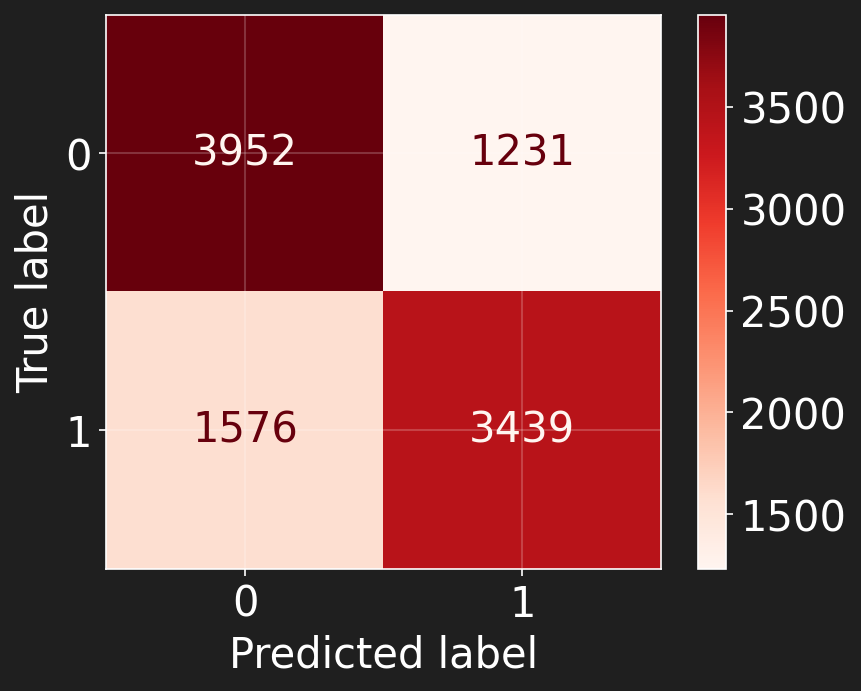

In [17]:
mv.score_evaluation="accuracy"
mv.evaluate_matrix()


# Discussion
___

Having an accuracy of 0.72 is not a great result, anything under 0.8 is, in most situation, an unacceptable result. And in the case of medical data it's likely that an accuracy above .9 would
be needed for the model to be deemed successful.  

But it is worth noting that even with only three test runs three different models came out on top, it would be interesting to see if a large dataset would have resulted in a more stable result. 

Dataset 2 however seemed to be the superior choices as it preformed the best in all three test runs. The differens between Dataset 1 and Dataset 2 is that Dataset 2 did not include the categorical data of Blood Pressure and BMI but instead relied on the continues versions of these features. 

The question is then, what could be done to increase the accuracy of the model?
  
1. Increased Processing Power
	With greater hardware a greater range of hyper parameters could have been tested and perhaps a greater combination of parameters could have been found. This could in turn improve the accuracy of the model. 

2. Feature Expansion
	There might be more correlation hidden in the data, with the use of feature expansion techniques such as increasing dimension, finding interactions between features and applying mathematical function such as logarithms and square roots to existing feature new features may be created that can better denote the target.

3. Testing More Versions of the Data Set 
	Two sets have already been tested but there are many more combinations, functions could have been rigged to, much like cross validation, test different combination of features.

4. Testing More Models
	There are plenty more classifications models to try out, models such as, Support Vector Classification, Random Forest Classifier, Quadratic Discriminant Analysis.

5. Find Better Data
	 The case could also be that we are missing some important feature, there where no clear indication of correlation in the heat map and this could suggest that some important piece of data is simply missing. Perhaps CVD has some genetic component hat can't easily be explained by the currant features, this could account for a huge amount of the correlation. All though one must remember that genetics in some way shape or form, be it directly or indirectly, effects all the features in the dataset, even habitual features such as smoking and drinking may be influenced by genetics.
	 
	 " Data analyses from the 1981 Australian twin panel cohort confirm a positive genetic correlation between regular smoking and the risk of alcohol dependence that remains significant, even when sociodemographic and personality variables as well as histories of other psychopathologies are taken into account. " (Madden Pamela, Bucholz Kathleen, Martin Nicholas, Heath Andrew. National Library Of Medicine Link: https://pmc.ncbi.nlm.nih.gov/articles/PMC6709744/)
	 
	So there is, theoretically, genetic information locked inside the features, and if the hypothetical genetic correlation does exist than perhaps this information could be unlocked with for example feature expansion that where discussed in point 2 or with other even more powerful feature engineering tools. Or one could simply solve it by finding a data set with other features or more observations, that could also be a solution. 